**This notebook focuses on the effectiveness of Spatial Smoothing against adversarial attacks on the CIFAR-10 dataset.**

## **Section 0 - Setting Up**

### **Load prerequisites**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, Layer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from art import config
from art.attacks.evasion import FastGradientMethod, DeepFool, ProjectedGradientDescent, SaliencyMapMethod, CarliniL2Method, NewtonFool, BasicIterativeMethod
from art.defences.preprocessor import SpatialSmoothing
from art.defences.trainer import AdversarialTrainer
from art.estimators.classification import KerasClassifier
from art.utils import load_cifar10

### **Disable eager execution to enable adversarial crafting and ART classifier**

In [2]:
tf.compat.v1.disable_eager_execution()

### **Load CIFAR-10 dataset**

In [3]:
def cifar10_class(class_number):
    switcher={
        0: 'Airplane',
        1: 'Automobile',
        2: 'Bird',
        3: 'Cat',
        4: 'Deer',
        5: 'Dog',
        6: 'Frog',
        7: 'Horse',
        8: 'Ship',
        9: 'Truck'
    }
    return switcher.get(class_number)

In [4]:
(x_train_cln, y_train_cln), (x_test_cln, y_test_cln), min_pixel_value, max_pixel_value = load_cifar10()
# x_test_cln, y_test_cln = x_test_cln[:1000], y_test_cln[:100]

### **Create CIFAR-10 classifier model**

*Load CIFAR-10 pre-trained model*

In [5]:
# model = load_model("/home/cyber/Desktop/Adrian/cifar10_trained_model.h5")
model = load_model("/Users/Adrian/Downloads/Sem 3.2/Models & Checkpoints/cifar10_trained_model.h5")

*Create ART classifier*

In [6]:
classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

## **Section 1 - Attack**

Step 1: Evaluate the classifier on the clean test set

In [7]:
predictions_cln = classifier.predict(x_test_cln)
accuracy_cln = np.sum(np.argmax(predictions_cln, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("Accuracy on clean test examples: {}%".format(accuracy_cln * 100))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Accuracy on clean test examples: 88.87%


Step 2: Split clean test examples into true and false positives

In [8]:
tp_cln_indexes=[]
fp_cln_indexes=[]
x_test_cln_tp=[]
y_test_cln_tp=[]
x_test_cln_fp=[]
y_test_cln_fp=[]

for k in range(len(predictions_cln)):
    if(np.argmax(predictions_cln, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k]):
        tp_cln_indexes.append(k)
    else:
        fp_cln_indexes.append(k)

for k in tp_cln_indexes:
    x_test_cln_tp.append(x_test_cln[k])
    y_test_cln_tp.append(y_test_cln[k])
    
for k in fp_cln_indexes:
    x_test_cln_fp.append(x_test_cln[k])
    y_test_cln_fp.append(y_test_cln[k])
    
x_test_cln_tp = np.array(x_test_cln_tp)
x_test_cln_fp = np.array(x_test_cln_fp)

print('Number of clean true positives: {:}'.format(len(x_test_cln_tp)))
print('Number of clean false positives: {:}'.format(len(x_test_cln_fp)))

Number of clean true positives: 8887
Number of clean false positives: 1113


Step 3: Craft adversarial examples

*Craft Jacobian-based Saliency Map Attack (JSMA) attacks*

In [9]:
# attack = SaliencyMapMethod(classifier=classifier, theta = 0.1, gamma=0.3, verbose=True)
# x_test_JSMA_cifar10 = attack.generate(x_test_cln)
# %store x_test_JSMA_cifar10

*Craft Basic Iterative Method (BMI) attacks*

In [10]:
# attack = BasicIterativeMethod(classifier, eps=0.3, eps_step=0.1, max_iter=100)
# x_test_BIM_cifar10 = attack.generate(x_test_cln)
# %store x_test_BIM_cifar10

*Craft Projected Gradient Descent (PGD) attacks*

In [11]:
# attack = ProjectedGradientDescent(classifier, eps=0.3, eps_step=0.1, max_iter=100)
# x_test_PGD_cifar10 = attack.generate(x_test_cln)
# %store x_test_PGD_cifar10

*Craft NewtonFool attacks*

In [12]:
# attack =  NewtonFool(classifier=classifier, eta=0.05, max_iter=100, verbose=True)
# x_test_Newton_cifar10 = attack.generate(x_test_cln)
# %store x_test_Newton_cifar10

*Craft DeepFool attacks*

In [13]:
# attack = DeepFool(classifier=classifier, epsilon=1e-06, max_iter=100)
# x_test_Deep_cifar10 = attack.generate(x_test_cln)
# %store x_test_Deep_cifar10

*Alternatively, load existing adversarial attacks*

In [21]:
attack_name = 'Deep'
%store -r x_test_Deep_cifar10
x_test_adv = x_test_Deep_cifar10

Step 4: Evaluate the classifier on the adversarial test set

In [22]:
predictions_adv = classifier.predict(x_test_adv)
accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("Accuracy on adversarial test examples: {}%".format(accuracy_adv * 100))

Accuracy on adversarial test examples: 8.92%


Step 5: Split the adversarial test examples into true and false positives

In [23]:
tp_adv_indexes=[]
fp_adv_indexes=[]
x_test_adv_tp=[]
y_test_adv_tp=[]
x_test_adv_fp=[]
y_test_adv_fp=[]

for k in range(len(predictions_adv)):
    if(np.argmax(predictions_adv, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k]):
        tp_adv_indexes.append(k)
    else:
        fp_adv_indexes.append(k)

for k in tp_adv_indexes:
    x_test_adv_tp.append(x_test_adv[k])
    y_test_adv_tp.append(y_test_cln[k])
    
for k in fp_adv_indexes:
    x_test_adv_fp.append(x_test_adv[k])
    y_test_adv_fp.append(y_test_cln[k])
    
x_test_adv_tp = np.array(x_test_adv_tp)
x_test_adv_fp = np.array(x_test_adv_fp)

print('Adversarial TP: {:}'.format(len(x_test_adv_tp)))
print('Adversarial FP: {:}'.format(len(x_test_adv_fp)))

Adversarial TP: 892
Adversarial FP: 9108


Step 6: Plot clean test examples and their adversarial counterparts

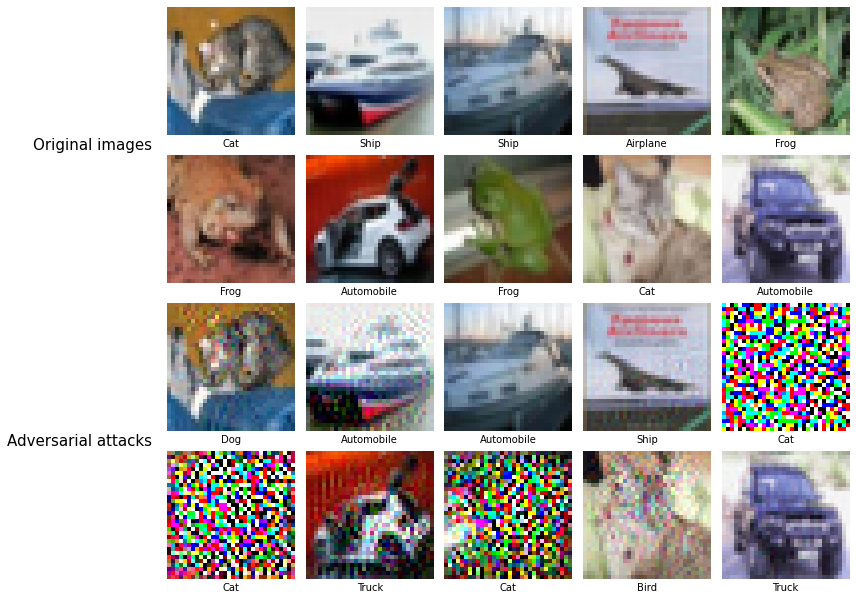

In [24]:
# Plot images before and after adversarial attack
plt.figure(figsize=(12,12))

for i in range(10):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(x_test_cln[i])
    ax.set_xlabel('{:}'.format(cifar10_class(np.argmax(y_test_cln,axis=1)[i]), labelpad=5, fontsize=12))
    
    ax = plt.subplot(4, 5, i + 11)
    plt.imshow(x_test_adv[i])
    ax.set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_adv,axis=1)[i]), labelpad=5, fontsize=12))

# Plot y-axis labels
ax1 = plt.subplot(4,5,1)
ax1.set_ylabel('Original images', rotation=0, va='center', ha='right', labelpad=15, fontsize=15, y=-0.08)

ax3 = plt.subplot(4,5,11)
ax3.set_ylabel('Adversarial attacks', rotation=0, va='center', ha='right', labelpad=15, fontsize=15, y=-0.08)

# Turn off axis for all plots
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[], frame_on=False)

# Adjusting space between subplots
plt.tight_layout()
plt.subplots_adjust(top=0.7)

# Save and show image
plt.show()

## **Section 2 - Defence**

### **Spatial Smoothing**

Step 1: Transform input

In [18]:
parameter = 6
defence = SpatialSmoothing(window_size=parameter)

In [19]:
x_test_cln_tp_ss = defence(x_test_cln_tp * 255)[0] / 255
x_test_cln_fp_ss = defence(x_test_cln_fp * 255)[0] / 255
x_test_cln_ss = np.concatenate((x_test_cln_tp_ss, x_test_cln_fp_ss), axis=0)
y_test_cln_ss = y_test_cln_tp + y_test_cln_fp

In [20]:
x_test_adv_tp_ss = defence(x_test_adv_tp * 255)[0] / 255
x_test_adv_fp_ss = defence(x_test_adv_fp * 255)[0] / 255
x_test_adv_ss = np.concatenate((x_test_adv_tp_ss, x_test_adv_fp_ss), axis=0)
y_test_adv_ss = y_test_adv_tp + y_test_adv_fp

Step 2: Evaluate the classifier on all 4 sets of data after Spatial Smoothing

In [264]:
print('\033[1mThe effect of Spatial Smoothing:\033[0m\n')

predictions_cln_ss = classifier.predict(x_test_cln_ss)
accuracy_cln_ss = np.sum(np.argmax(predictions_cln_ss, axis=1) == np.argmax(y_test_cln_ss, axis=1)) / len(y_test_cln_ss)

print("On entire \033[1mclean test set\033[0m: {:.2f}%".format((accuracy_cln_ss - accuracy_cln) * 100))
 
predictions_cln_tp_ss = classifier.predict(x_test_cln_tp_ss)
accuracy_cln_tp_ss = np.sum(np.argmax(predictions_cln_tp_ss, axis=1) == np.argmax(y_test_cln_tp, axis=1)) / len(y_test_cln_tp)

# print("\nAccuracy on TP clean test examples after TotalVarMin: {:.2f}%".format(accuracy_cln_tp_ss * 100))
print("\nAccuracy drop on clean TP examples: {:.2f}%".format((1 - accuracy_cln_tp_ss) * 100))

predictions_cln_fp_ss = classifier.predict(x_test_cln_fp_ss)
accuracy_cln_fp_ss = np.sum(np.argmax(predictions_cln_fp_ss, axis=1) == np.argmax(y_test_cln_fp, axis=1)) / len(y_test_cln_fp)

print("\nAccuracy increase on clean FP examples: {:.2f}%".format(accuracy_cln_fp_ss * 100))

predictions_adv_ss = classifier.predict(x_test_adv_ss)
accuracy_adv_ss = np.sum(np.argmax(predictions_adv_ss, axis=1) == np.argmax(y_test_adv_ss, axis=1)) / len(y_test_adv_ss)

print("\nOn entire \033[1madversarial test set\033[0m: +{:.2f}%".format((accuracy_adv_ss-accuracy_adv) * 100))

predictions_adv_tp_ss = classifier.predict(x_test_adv_tp_ss)
accuracy_adv_tp_ss = np.sum(np.argmax(predictions_adv_tp_ss, axis=1) == np.argmax(y_test_adv_tp, axis=1)) / len(y_test_adv_tp)

# print("\nAccuracy on TP adversarial test examples after TotalVarMin: {:.2f}%".format(accuracy_adv_tp_ss * 100))
print("\nAccuracy drop on adversarial TP examples: {:.2f}%".format((1 - accuracy_adv_tp_ss) * 100))

predictions_adv_fp_ss = classifier.predict(x_test_adv_fp_ss)
accuracy_adv_fp_ss = np.sum(np.argmax(predictions_adv_fp_ss, axis=1) == np.argmax(y_test_adv_fp, axis=1)) / len(y_test_adv_fp)

print("\nAccuracy increase on adversarial FP examples: {:.2f}%".format(accuracy_adv_fp_ss * 100))

Effect of Spatial Smoothing on entire clean test set: -38.38%

Accuracy drop on true positive clean test examples after Spatial Smoothing: 46.43%

Accuracy increase on false positive clean test examples after Spatial Smoothing: 25.88%

Effect of Spatial Smoothing on entire adversarial test set: 40.61%

Accuracy drop on true positive adversarial test examples after Spatial Smoothing: 66.37%

Accuracy increase on false positive adversarial test examples after Spatial Smoothing: 48.47%


Step 3: Plot all data pre- and post-transformation

In [265]:
# Get index of successful Spatial Smoothing transformations
succ_cln_tp_idx=[]
succ_cln_fp_idx=[]
succ_adv_tp_idx=[]
succ_adv_fp_idx=[]


for k in range(len(predictions_cln_tp_ss)):
    if(np.argmax(predictions_cln_tp_ss, axis=1)[k] == np.argmax(y_test_cln_tp, axis=1)[k]):
        succ_cln_tp_idx.append(k)
        
for k in range(len(predictions_cln_fp_ss)):
    if(np.argmax(predictions_cln_fp_ss, axis=1)[k] == np.argmax(y_test_cln_fp, axis=1)[k]):
        succ_cln_fp_idx.append(k)
        
for k in range(len(predictions_adv_tp_ss)):
    if(np.argmax(predictions_adv_tp_ss, axis=1)[k] == np.argmax(y_test_adv_tp, axis=1)[k]):
        succ_adv_tp_idx.append(k)
        
for k in range(len(predictions_adv_fp_ss)):
    if(np.argmax(predictions_adv_fp_ss, axis=1)[k] == np.argmax(y_test_adv_fp, axis=1)[k]):
        succ_adv_fp_idx.append(k)
        
# Get predictions of data before transformation

predictions_cln_tp = classifier.predict(x_test_cln_tp)
predictions_cln_fp = classifier.predict(x_test_cln_fp)
predictions_adv_tp = classifier.predict(x_test_adv_tp)
predictions_adv_fp = classifier.predict(x_test_adv_fp)

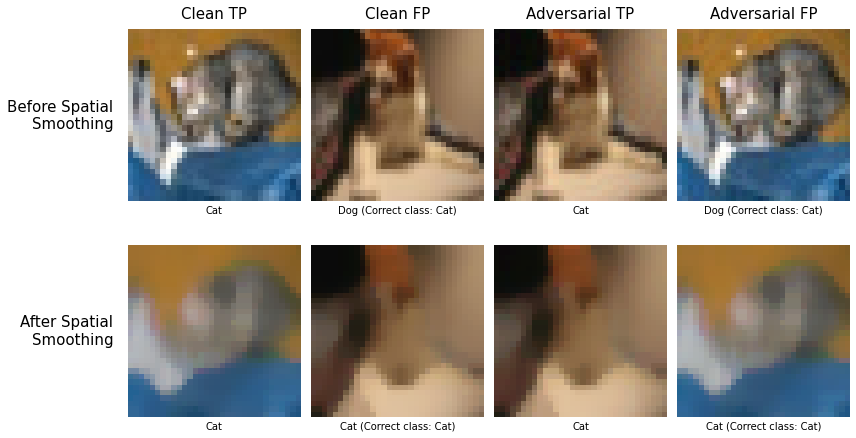

In [266]:
# Plot images before and after Spatial Smoothing
fig, axs = plt.subplots(2, 4, figsize=(12,12))

# Plot super title
fig.suptitle('Window Size = {:}''.format(parameter), y=0.62, x=0.57, fontsize=20)

# Plot x-axis labels
axs[0,0].set_title('Clean TP', va='center', ha='center', pad=15, fontsize=15)
axs[0,1].set_title('Clean FP', va='center', ha='center', pad=15, fontsize=15)
axs[0,2].set_title('Adversarial TP', va='center', ha='center', pad=15, fontsize=15)
axs[0,3].set_title('Adversarial FP', va='center', ha='center', pad=15, fontsize=15)

# Plot y-axis labels
axs[0,0].set_ylabel('Before Spatial\nSmoothing', rotation=0, va='center', ha='right', labelpad=15, fontsize=15)
axs[1,0].set_ylabel('After Spatial\nSmoothing', rotation=0, va='center', ha='right', labelpad=15, fontsize=15)

# Plot clean true positives
axs[0,0].imshow(x_test_cln_tp[succ_cln_tp_idx[0]])
axs[0,0].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_cln_tp,axis=1)[succ_cln_tp_idx[0]]), fontsize=12, loc='center', wrap=True))

axs[1,0].imshow(x_test_cln_tp_ss[succ_cln_tp_idx[0]])
axs[1,0].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_cln_tp_ss,axis=1)[succ_cln_tp_idx[0]]), fontsize=12, loc='center', wrap=True))

# Plot clean false positives
axs[0,1].imshow(x_test_cln_fp[succ_cln_fp_idx[0]])
axs[0,1].set_xlabel('{:} (Correct class: {:})'.format(cifar10_class(np.argmax(predictions_cln_fp,axis=1)[succ_cln_fp_idx[0]]), cifar10_class(np.argmax(y_test_cln_fp,axis=1)[succ_cln_fp_idx[0]]), fontsize=12, loc='center', wrap=True))

axs[1,1].imshow(x_test_cln_fp_ss[succ_cln_fp_idx[0]])
axs[1,1].set_xlabel('{:} (Correct class: {:})'.format(cifar10_class(np.argmax(predictions_cln_fp_ss,axis=1)[succ_cln_fp_idx[0]]), cifar10_class(np.argmax(y_test_cln_fp,axis=1)[succ_cln_fp_idx[0]]), fontsize=12, loc='center', wrap=True))

# Plot adversarial true positives
axs[0,2].imshow(x_test_adv_tp[succ_adv_tp_idx[0]])
axs[0,2].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_adv_tp,axis=1)[succ_adv_tp_idx[0]]), fontsize=12, loc='center', wrap=True))

axs[1,2].imshow(x_test_adv_tp_ss[succ_adv_tp_idx[0]])
axs[1,2].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_adv_tp_ss,axis=1)[succ_adv_tp_idx[0]]), fontsize=12, loc='center', wrap=True))

# Plot adversarial false positivies
axs[0,3].imshow(x_test_adv_fp[succ_adv_fp_idx[0]])
axs[0,3].set_xlabel('{:} (Correct class: {:})'.format(cifar10_class(np.argmax(predictions_adv_fp,axis=1)[succ_adv_fp_idx[0]]), cifar10_class(np.argmax(y_test_adv_fp,axis=1)[succ_adv_fp_idx[0]]), fontsize=12, loc='center', wrap=True))

axs[1,3].imshow(x_test_adv_fp_ss[succ_adv_fp_idx[0]])
axs[1,3].set_xlabel('{:} (Correct class: {:})'.format(cifar10_class(np.argmax(predictions_adv_fp_ss,axis=1)[succ_adv_fp_idx[0]]), cifar10_class(np.argmax(y_test_adv_fp,axis=1)[succ_adv_fp_idx[0]]), fontsize=12, loc='center', wrap=True))

# Turn off axis for all plots
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[], frame_on=False)

# Adjusting space between subplots
plt.tight_layout()
fig.subplots_adjust(top=0.6)

# Save and show image
image_path = '/home/cyber/Desktop/Adrian/Plots/SpatialSmoothing/SpatialSmoothing_WindowSize={:}_CIFAR-10_{:}.png'.format(parameter, attack_name)
plt.savefig(image_path, dpi=500, transparent=True, bbox_inches='tight')
plt.show()

## Others

In [20]:
%store -r x_test_BIM_cifar10
%store -r x_test_JSMA_cifar10
%store -r x_test_Deep_cifar10
%store -r x_test_Newton_cifar10
%store -r x_test_PGD_cifar10

predictions_cln = classifier.predict(x_test_cln)
predictions_jsma = classifier.predict(x_test_JSMA_cifar10)
predictions_bim = classifier.predict(x_test_BIM_cifar10)
predictions_deep = classifier.predict(x_test_Deep_cifar10)
predictions_newton = classifier.predict(x_test_Newton_cifar10)
predictions_pgd = classifier.predict(x_test_PGD_cifar10)

In [22]:
from art.defences.preprocessor import SpatialSmoothing

ss = SpatialSmoothing(window_size=2)
cln_ss2 = ss(x_test_cln)[0]
jsma_ss2 = ss(x_test_JSMA_cifar10)[0]
bim_ss2 = ss(x_test_BIM_cifar10)[0]
deep_ss2 = ss(x_test_Deep_cifar10)[0]
newton_ss2 = ss(x_test_Newton_cifar10)[0]
pgd_ss2 = ss(x_test_PGD_cifar10)[0]

ss = SpatialSmoothing(window_size=3)
cln_ss3 = ss(x_test_cln)[0]
jsma_ss3 = ss(x_test_JSMA_cifar10)[0]
bim_ss3 = ss(x_test_BIM_cifar10)[0]
deep_ss3 = ss(x_test_Deep_cifar10)[0]
newton_ss3 = ss(x_test_Newton_cifar10)[0]
pgd_ss3 = ss(x_test_PGD_cifar10)[0]

ss = SpatialSmoothing(window_size=4)
cln_ss4 = ss(x_test_cln)[0]
jsma_ss4 = ss(x_test_JSMA_cifar10)[0]
bim_ss4 = ss(x_test_BIM_cifar10)[0]
deep_ss4 = ss(x_test_Deep_cifar10)[0]
newton_ss4 = ss(x_test_Newton_cifar10)[0]
pgd_ss4 = ss(x_test_PGD_cifar10)[0]

ss = SpatialSmoothing(window_size=5)
cln_ss5 = ss(x_test_cln)[0]
jsma_ss5 = ss(x_test_JSMA_cifar10)[0]
bim_ss5 = ss(x_test_BIM_cifar10)[0]
deep_ss5 = ss(x_test_Deep_cifar10)[0]
newton_ss5 = ss(x_test_Newton_cifar10)[0]
pgd_ss5 = ss(x_test_PGD_cifar10)[0]

ss = SpatialSmoothing(window_size=6)
cln_ss6 = ss(x_test_cln)[0]
jsma_ss6 = ss(x_test_JSMA_cifar10)[0]
bim_ss6 = ss(x_test_BIM_cifar10)[0]
deep_ss6 = ss(x_test_Deep_cifar10)[0]
newton_ss6 = ss(x_test_Newton_cifar10)[0]
pgd_ss6 = ss(x_test_PGD_cifar10)[0]

predictions_cln_ss2 = classifier.predict(cln_ss2)
predictions_jsma_ss2 = classifier.predict(jsma_ss2)
predictions_bim_ss2 = classifier.predict(bim_ss2)
predictions_deep_ss2 = classifier.predict(deep_ss2)
predictions_newton_ss2 = classifier.predict(newton_ss2)
predictions_pgd_ss2 = classifier.predict(pgd_ss2)

predictions_cln_ss3 = classifier.predict(cln_ss3)
predictions_jsma_ss3 = classifier.predict(jsma_ss3)
predictions_bim_ss3 = classifier.predict(bim_ss3)
predictions_deep_ss3 = classifier.predict(deep_ss3)
predictions_newton_ss3 = classifier.predict(newton_ss3)
predictions_pgd_ss3 = classifier.predict(pgd_ss3)

predictions_cln_ss4 = classifier.predict(cln_ss4)
predictions_jsma_ss4 = classifier.predict(jsma_ss4)
predictions_bim_ss4 = classifier.predict(bim_ss4)
predictions_deep_ss4 = classifier.predict(deep_ss4)
predictions_newton_ss4 = classifier.predict(newton_ss4)
predictions_pgd_ss4 = classifier.predict(pgd_ss4)

predictions_cln_ss5 = classifier.predict(cln_ss5)
predictions_jsma_ss5 = classifier.predict(jsma_ss5)
predictions_bim_ss5 = classifier.predict(bim_ss5)
predictions_deep_ss5 = classifier.predict(deep_ss5)
predictions_newton_ss5 = classifier.predict(newton_ss5)
predictions_pgd_ss5 = classifier.predict(pgd_ss5)

predictions_cln_ss6 = classifier.predict(cln_ss6)
predictions_jsma_ss6 = classifier.predict(jsma_ss6)
predictions_bim_ss6 = classifier.predict(bim_ss6)
predictions_deep_ss6 = classifier.predict(deep_ss6)
predictions_newton_ss6 = classifier.predict(newton_ss6)
predictions_pgd_ss6 = classifier.predict(pgd_ss6)

In [31]:
cln_idx=[]
bim_idx=[]
jsma_idx=[]
deep_idx=[]
newton_idx=[]
pgd_idx=[]

for k in range(len(predictions_bim_ss2)):
    if(np.argmax(predictions_cln_ss2, axis=1)[k] == np.argmax(predictions_cln_ss3, axis=1)[k] == np.argmax(predictions_cln_ss4, axis=1)[k] == np.argmax(predictions_cln_ss5, axis=1)[k] == np.argmax(predictions_cln_ss6, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k]):
        cln_idx.append(k)
        
for k in range(len(predictions_bim_ss2)):
    if(np.argmax(predictions_bim_ss2, axis=1)[k] == np.argmax(predictions_bim_ss3, axis=1)[k] == np.argmax(predictions_bim_ss4, axis=1)[k] == np.argmax(predictions_bim_ss5, axis=1)[k] == np.argmax(predictions_bim_ss6, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k] != np.argmax(predictions_bim, axis=1)[k]):
        bim_idx.append(k)
    
for k in range(len(predictions_jsma_ss2)):
    if(np.argmax(predictions_jsma_ss2, axis=1)[k] == np.argmax(predictions_jsma_ss3, axis=1)[k] == np.argmax(predictions_jsma_ss4, axis=1)[k] == np.argmax(predictions_jsma_ss5, axis=1)[k] == np.argmax(predictions_jsma_ss6, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k] != np.argmax(predictions_jsma, axis=1)[k]):
        jsma_idx.append(k)
        
for k in range(len(predictions_deep_ss2)):
    if(np.argmax(predictions_deep_ss2, axis=1)[k] == np.argmax(predictions_deep_ss3, axis=1)[k] == np.argmax(predictions_deep_ss4, axis=1)[k] == np.argmax(predictions_deep_ss5, axis=1)[k] == np.argmax(predictions_deep_ss6, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k] != np.argmax(predictions_deep, axis=1)[k]):
        deep_idx.append(k)

for k in range(len(predictions_newton_ss2)):
    if(np.argmax(predictions_newton_ss2, axis=1)[k] == np.argmax(predictions_newton_ss3, axis=1)[k] == np.argmax(predictions_newton_ss4, axis=1)[k] == np.argmax(predictions_newton_ss5, axis=1)[k] == np.argmax(predictions_newton_ss6, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k] != np.argmax(predictions_newton, axis=1)[k]):
        newton_idx.append(k)

for k in range(len(predictions_pgd_ss2)):
    if(np.argmax(predictions_pgd_ss2, axis=1)[k] == np.argmax(predictions_pgd_ss3, axis=1)[k] == np.argmax(predictions_pgd_ss4, axis=1)[k] == np.argmax(predictions_pgd_ss5, axis=1)[k] == np.argmax(predictions_pgd_ss6, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k] != np.argmax(predictions_pgd, axis=1)[k]):
        pgd_idx.append(k)

In [45]:
cln = cln_idx[0]
bim = bim_idx[4]
jsma = jsma_idx[2]
deep = deep_idx[3]
newton = newton_idx[4]
pgd = pgd_idx[5]

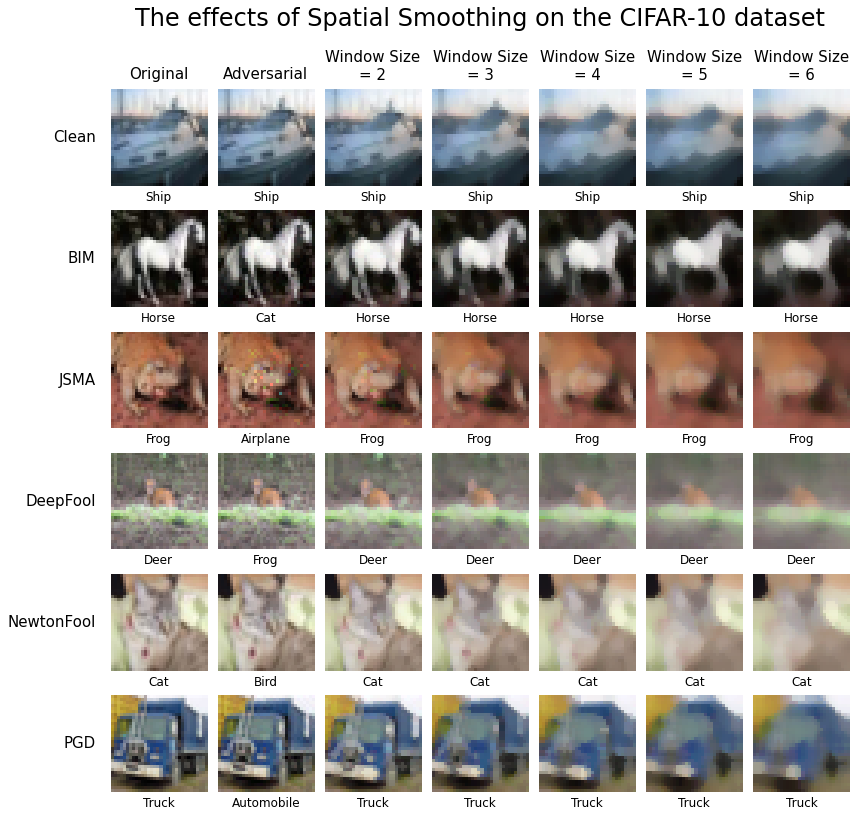

In [48]:
# Plot images before and after Spatial Smoothing
fig, axs = plt.subplots(6, 7, figsize=(12,12))

# Plot super title
fig.suptitle('The effects of Spatial Smoothing on the CIFAR-10 dataset', y=0.94, x=0.56, fontsize=24)

# Plot x-axis labels
axs[0,0].set_title('Original', va='center', ha='center', pad=15, fontsize=15)
axs[0,1].set_title('Adversarial', va='center', ha='center', pad=15, fontsize=15)
axs[0,2].set_title('Window Size\n= 2', va='center', ha='center', pad=25, fontsize=15)
axs[0,3].set_title('Window Size\n= 3', va='center', ha='center', pad=25, fontsize=15)
axs[0,4].set_title('Window Size\n= 4', va='center', ha='center', pad=25, fontsize=15)
axs[0,5].set_title('Window Size\n= 5', va='center', ha='center', pad=25, fontsize=15)
axs[0,6].set_title('Window Size\n= 6', va='center', ha='center', pad=25, fontsize=15)

# Plot y-axis labels
axs[0,0].set_ylabel('Clean', rotation=0, va='center', ha='right', labelpad=15, fontsize=15)
axs[1,0].set_ylabel('BIM', rotation=0, va='center', ha='right', labelpad=15, fontsize=15)
axs[2,0].set_ylabel('JSMA', rotation=0, va='center', ha='right', labelpad=15, fontsize=15)
axs[3,0].set_ylabel('DeepFool', rotation=0, va='center', ha='right', labelpad=15, fontsize=15)
axs[4,0].set_ylabel('NewtonFool', rotation=0, va='center', ha='right', labelpad=15, fontsize=15)
axs[5,0].set_ylabel('PGD', rotation=0, va='center', ha='right', labelpad=15, fontsize=15)

# Plot original images
axs[0,0].imshow(x_test_cln[cln], cmap='gray')
axs[0,0].set_xlabel('{:}'.format(cifar10_class(np.argmax(y_test_cln,axis=1)[cln])), labelpad=5, fontsize=12)

axs[1,0].imshow(x_test_cln[bim], cmap='gray')
axs[1,0].set_xlabel('{:}'.format(cifar10_class(np.argmax(y_test_cln,axis=1)[bim])), labelpad=5, fontsize=12)

axs[2,0].imshow(x_test_cln[jsma], cmap='gray')
axs[2,0].set_xlabel('{:}'.format(cifar10_class(np.argmax(y_test_cln,axis=1)[jsma])), labelpad=5, fontsize=12)

axs[3,0].imshow(x_test_cln[deep], cmap='gray')
axs[3,0].set_xlabel('{:}'.format(cifar10_class(np.argmax(y_test_cln,axis=1)[deep])), labelpad=5, fontsize=12)

axs[4,0].imshow(x_test_cln[newton], cmap='gray')
axs[4,0].set_xlabel('{:}'.format(cifar10_class(np.argmax(y_test_cln,axis=1)[newton])), labelpad=5, fontsize=12)

axs[5,0].imshow(x_test_cln[pgd], cmap='gray')
axs[5,0].set_xlabel('{:}'.format(cifar10_class(np.argmax(y_test_cln,axis=1)[pgd])), labelpad=5, fontsize=12)

# Plot adversarial examples
axs[0,1].imshow(x_test_cln[cln], cmap='gray')
axs[0,1].set_xlabel('{:}'.format(cifar10_class(np.argmax(y_test_cln,axis=1)[cln])), labelpad=5, fontsize=12)

axs[1,1].imshow(x_test_BIM_cifar10[bim], cmap='gray')
axs[1,1].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_bim,axis=1)[bim])), labelpad=5, fontsize=12)

axs[2,1].imshow(x_test_JSMA_cifar10[jsma], cmap='gray')
axs[2,1].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_jsma,axis=1)[jsma])), labelpad=5, fontsize=12)

axs[3,1].imshow(x_test_Deep_cifar10[deep], cmap='gray')
axs[3,1].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_deep,axis=1)[deep])), labelpad=5, fontsize=12)

axs[4,1].imshow(x_test_Newton_cifar10[newton], cmap='gray')
axs[4,1].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_newton,axis=1)[newton])), labelpad=5, fontsize=12)

axs[5,1].imshow(x_test_PGD_cifar10[pgd], cmap='gray')
axs[5,1].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_pgd,axis=1)[pgd])), labelpad=5, fontsize=12)

# Plot spatial smoothing windowsize = 2
axs[0,2].imshow(cln_ss2[cln], cmap='gray')
axs[0,2].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_cln_ss2,axis=1)[cln])), labelpad=5, fontsize=12)

axs[1,2].imshow(bim_ss2[bim], cmap='gray')
axs[1,2].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_bim_ss2,axis=1)[bim])), labelpad=5, fontsize=12)

axs[2,2].imshow(jsma_ss2[jsma], cmap='gray')
axs[2,2].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_jsma_ss2,axis=1)[jsma])), labelpad=5, fontsize=12)

axs[3,2].imshow(deep_ss2[deep], cmap='gray')
axs[3,2].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_deep_ss2,axis=1)[deep])), labelpad=5, fontsize=12)

axs[4,2].imshow(newton_ss2[newton], cmap='gray')
axs[4,2].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_newton_ss2,axis=1)[newton])), labelpad=5, fontsize=12)

axs[5,2].imshow(pgd_ss2[pgd], cmap='gray')
axs[5,2].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_pgd_ss2,axis=1)[pgd])), labelpad=5, fontsize=12)

# Plot spatial smoothing windowsize = 3
axs[0,3].imshow(cln_ss3[cln], cmap='gray')
axs[0,3].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_cln_ss3,axis=1)[cln])), labelpad=5, fontsize=12)

axs[1,3].imshow(bim_ss3[bim], cmap='gray')
axs[1,3].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_bim_ss3,axis=1)[bim])), labelpad=5, fontsize=12)
 
axs[2,3].imshow(jsma_ss3[jsma], cmap='gray')
axs[2,3].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_jsma_ss3,axis=1)[jsma])), labelpad=5, fontsize=12)

axs[3,3].imshow(deep_ss3[deep], cmap='gray')
axs[3,3].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_deep_ss3,axis=1)[deep])), labelpad=5, fontsize=12)

axs[4,3].imshow(newton_ss3[newton], cmap='gray')
axs[4,3].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_newton_ss3,axis=1)[newton])), labelpad=5, fontsize=12)

axs[5,3].imshow(pgd_ss3[pgd], cmap='gray')
axs[5,3].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_pgd_ss3,axis=1)[pgd])), labelpad=5, fontsize=12)

# Plot spatial smoothing windowsize = 4
axs[0,4].imshow(cln_ss4[cln], cmap='gray')
axs[0,4].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_cln_ss4,axis=1)[cln])), labelpad=5, fontsize=12)

axs[1,4].imshow(bim_ss4[bim], cmap='gray')
axs[1,4].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_bim_ss4,axis=1)[bim])), labelpad=5, fontsize=12)
 
axs[2,4].imshow(jsma_ss4[jsma], cmap='gray')
axs[2,4].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_jsma_ss4,axis=1)[jsma])), labelpad=5, fontsize=12)

axs[3,4].imshow(deep_ss4[deep], cmap='gray')
axs[3,4].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_deep_ss4,axis=1)[deep])), labelpad=5, fontsize=12)

axs[4,4].imshow(newton_ss4[newton], cmap='gray')
axs[4,4].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_newton_ss4,axis=1)[newton])), labelpad=5, fontsize=12)

axs[5,4].imshow(pgd_ss4[pgd], cmap='gray')
axs[5,4].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_pgd_ss4,axis=1)[pgd])), labelpad=5, fontsize=12)

# Plot spatial smoothing windowsize = 5
axs[0,5].imshow(cln_ss5[cln], cmap='gray')
axs[0,5].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_cln_ss5,axis=1)[cln])), labelpad=5, fontsize=12)

axs[1,5].imshow(bim_ss5[bim], cmap='gray')
axs[1,5].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_bim_ss5,axis=1)[bim])), labelpad=5, fontsize=12)
 
axs[2,5].imshow(jsma_ss5[jsma], cmap='gray')
axs[2,5].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_jsma_ss5,axis=1)[jsma])), labelpad=5, fontsize=12)

axs[3,5].imshow(deep_ss5[deep], cmap='gray')
axs[3,5].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_deep_ss5,axis=1)[deep])), labelpad=5, fontsize=12)

axs[4,5].imshow(newton_ss5[newton], cmap='gray')
axs[4,5].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_newton_ss5,axis=1)[newton])), labelpad=5, fontsize=12)

axs[5,5].imshow(pgd_ss5[pgd], cmap='gray')
axs[5,5].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_pgd_ss5,axis=1)[pgd])), labelpad=5, fontsize=12)

# Plot spatial smoothing windowsize = 6
axs[0,6].imshow(cln_ss6[cln], cmap='gray')
axs[0,6].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_cln_ss6,axis=1)[cln])), labelpad=5, fontsize=12)

axs[1,6].imshow(bim_ss6[bim], cmap='gray')
axs[1,6].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_bim_ss6,axis=1)[bim])), labelpad=5, fontsize=12)
 
axs[2,6].imshow(jsma_ss6[jsma], cmap='gray')
axs[2,6].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_jsma_ss6,axis=1)[jsma])), labelpad=5, fontsize=12)

axs[3,6].imshow(deep_ss6[deep], cmap='gray')
axs[3,6].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_deep_ss6,axis=1)[deep])), labelpad=5, fontsize=12)

axs[4,6].imshow(newton_ss6[newton], cmap='gray')
axs[4,6].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_newton_ss6,axis=1)[newton])), labelpad=5, fontsize=12)

axs[5,6].imshow(pgd_ss6[pgd], cmap='gray')
axs[5,6].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_pgd_ss6,axis=1)[pgd])), labelpad=5, fontsize=12)

# Turn off axis for all plots
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[], frame_on=False)

# Adjusting space between subplots
plt.tight_layout()
fig.subplots_adjust(top=0.85)

# Save and show image
image_path = '/Users/Adrian/Downloads/Sem 3.2/Interim & final report/SpatialSmoothing_CIFAR-10_Reference.png'
plt.savefig(image_path, dpi=1000, transparent=True, bbox_inches='tight')
plt.show()

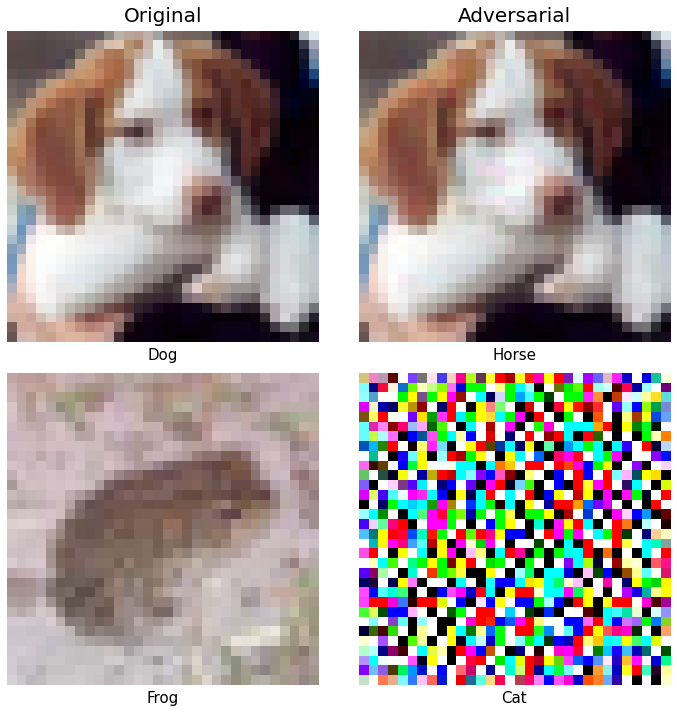

In [27]:
# Plot images before and after adversarial attack
fig, axs = plt.subplots(2,2, figsize=(10,10))

axs[0,0].set_title('Original', va='center', ha='center', pad=15, fontsize=20)
axs[0,1].set_title('Adversarial', va='center', ha='center', pad=15, fontsize=20)

axs[0,0].imshow(x_test_cln[16], cmap='gray')
axs[0,0].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_cln,axis=1)[16])), labelpad=5, fontsize=15)

axs[0,1].imshow(x_test_Deep_cifar10[16], cmap='gray')
axs[0,1].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_adv,axis=1)[16])), labelpad=5, fontsize=15)

axs[1,0].imshow(x_test_cln[282], cmap='gray')
axs[1,0].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_cln,axis=1)[282])), labelpad=5, fontsize=15)

axs[1,1].imshow(x_test_Deep_cifar10[282], cmap='gray')
axs[1,1].set_xlabel('{:}'.format(cifar10_class(np.argmax(predictions_adv,axis=1)[282])), labelpad=5, fontsize=15)

        
# Turn off axis for all plots
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[], frame_on=False)

# Adjusting space between subplots
plt.tight_layout()
# plt.subplots_adjust()

# Save and show image
image_path = '/Users/Adrian/Downloads/Sem 3.2/Interim & final report/DeepFool_Perturbations_CIFAR-10_Reference.png'
plt.savefig(image_path, dpi=1000, transparent=True, bbox_inches='tight')
plt.show()